In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import sys
from tqdm import tqdm

In [29]:
def llike(data_y_error, data_x, alpha_prop, sigma):
    
    first_term = -(N_obs/2) * np.log(2 * np.pi * (sigma**2))
    second_term = -(1/(2 * sigma**2)) * np.sum((data_y_error - (alpha_prop * data_x))**2)
    
    
    return(second_term)

In [30]:
def lprior_uniform(param, param_low_val, param_high_val):
    """
    Set uniform priors on parameters with select ranges.
    """
    if param < param_low_val or param > param_high_val:
        return -np.inf
    else:
        return 0

In [31]:
def lpost(data_y_error, data_x, alpha_prop, sigma, param, param_low_range = 0, param_high_range = 8):
    '''
    Compute log posterior - require log likelihood and log prior.
    '''
    return(lprior_uniform(param, param_low_range, param_high_range) + llike(data_y_error, data_x, alpha_prop, sigma))

In [32]:
def accept_reject(lp_prop, lp_prev):
    '''
    Compute log acceptance probability (minimum of 0 and log acceptance rate)
    Decide whether to accept (1) or reject (0)
    '''
    u = np.random.uniform(size = 1)  # U[0, 1]
    logalpha = np.minimum(0, lp_prop - lp_prev)  # log acceptance probability
    if np.log(u) < logalpha:
        return(1)  # Accept
    else:
        return(0)  # Reject

In [60]:
def MCMC_run(data_y_error, data_x, sigma, Ntotal, burnin, param_start, alpha_true, alpha_var_prop):
    '''
    Metropolis MCMC sampler
    '''

    # Set starting values

    alpha_chain = [param_start[0]]
                                           
    # Initial value for log posterior
    lp = []
    lp.append(lpost(data_y_error, data_x, alpha_chain[0], sigma, alpha_chain[0])) # Append first value of log posterior 
    
    lp_store = lp[0]  # Create log posterior storage to be overwritten

    #####                                                  
    # Run MCMC
    #####
    accept_reject_count = [1]

    for i in tqdm(range(1, Ntotal)):
        if i % 30000 == 0:
            print("Accept, reject ratio is", sum(accept_reject_count)/len(accept_reject_count))

        lp_prev = lp_store  # Call previous stored log posterior
        
        # Propose new points according to a normal proposal distribution of fixed variance 

        alpha_prop = np.random.normal(alpha_chain[i - 1], np.sqrt(alpha_var_prop))

    
        # Compute log posterior
        lp_prop = lpost(data_y_error, data_x, alpha_prop, sigma, alpha_prop)
        
        if accept_reject(lp_prop, lp_prev) == 1:  # Accept
            alpha_chain.append(alpha_prop)    # accept a_{prop} as new sample
            accept_reject_count.append(1)
            lp_store = lp_prop  # Overwrite lp_store
        else:  # Reject, if this is the case we use previously accepted values
            alpha_chain.append(alpha_chain[i - 1])  
            accept_reject_count.append(0)

        lp.append(lp_store)
    
    # Recast as .nparrays

    alpha_chain = np.array(alpha_chain)

    
    return alpha_chain, lp  # Return chains and log posterior.

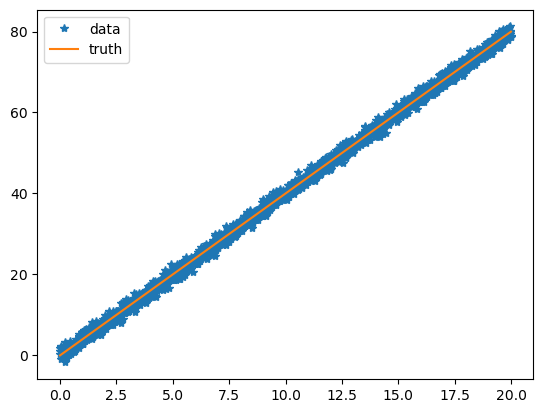

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

np.random.seed(1234)
np.random.seed(0)

alpha_true = 4
sigma = 1

data_x = np.arange(0,20,0.01)

N_obs = len(data_x)

eps = np.random.normal(0,sigma,N_obs)


data_y_error = alpha_true * data_x + eps
data_y_true = alpha_true * data_x

plt.plot(data_x,data_y_error,"*",label = "data")
plt.plot(data_x,data_y_true,label = "truth")

plt.legend()


In [68]:
param_start =[3.5]
Ntotal = 300000  # Total number of iterations
burnin = 60000   # Set burn-in. This is the amount of samples we will discard whilst looking 
                # for the true parameters
alpha_var_prop = 0.0001

In [69]:
alpha_chain, lp = MCMC_run(data_y_error, data_x, sigma, Ntotal, burnin, param_start, alpha_true, alpha_var_prop)

 13%|████████████▏                                                                                   | 38022/299999 [00:00<00:03, 71544.51it/s]

Accept, reject ratio is 0.23686666666666667


 23%|█████████████████████▋                                                                          | 67810/299999 [00:00<00:03, 73759.29it/s]

Accept, reject ratio is 0.23475


 32%|███████████████████████████████                                                                 | 97121/299999 [00:01<00:03, 65009.94it/s]

Accept, reject ratio is 0.23504444444444444


 44%|██████████████████████████████████████████                                                     | 133013/299999 [00:01<00:02, 70103.87it/s]

Accept, reject ratio is 0.23598333333333332


 54%|██████████████████████████████████████████████████▉                                            | 160968/299999 [00:02<00:02, 62705.09it/s]

Accept, reject ratio is 0.23634666666666668


 63%|███████████████████████████████████████████████████████████▍                                   | 187525/299999 [00:02<00:01, 60817.00it/s]

Accept, reject ratio is 0.23694444444444446


 73%|█████████████████████████████████████████████████████████████████████▌                         | 219854/299999 [00:03<00:01, 58142.06it/s]

Accept, reject ratio is 0.2363761904761905


 83%|██████████████████████████████████████████████████████████████████████████████▋                | 248482/299999 [00:03<00:00, 68075.07it/s]

Accept, reject ratio is 0.236125


 93%|████████████████████████████████████████████████████████████████████████████████████████▎      | 278978/299999 [00:04<00:00, 73863.73it/s]

Accept, reject ratio is 0.2359851851851852


100%|███████████████████████████████████████████████████████████████████████████████████████████████| 299999/299999 [00:04<00:00, 67149.59it/s]


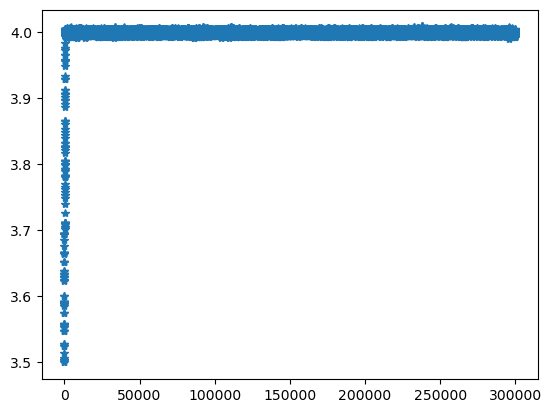

In [70]:
plt.plot(alpha_chain,'*')

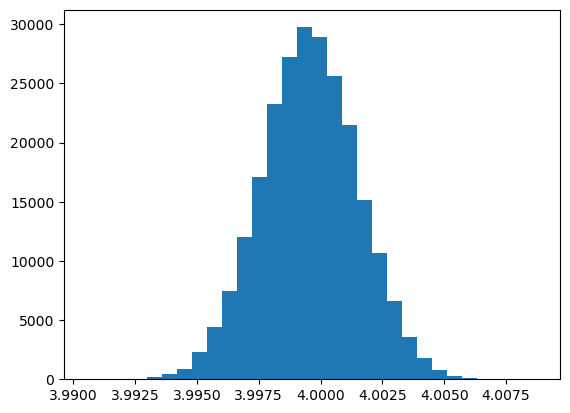

In [71]:
plt.hist(alpha_chain[burnin:], bins = 30)
plt.show()